In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Создадим датафреймы на основе предоставленных данных
events = pd.read_csv("./data/events.csv")

category_tree = pd.read_csv("./data/category_tree.csv")

properties_1 = pd.read_csv("./data/item_properties_part1.csv")
properties_2 = pd.read_csv("./data/item_properties_part2.csv")
item_properties = pd.concat([properties_1, properties_2])

# Приведем к временному формату данные из timestapm
events["timestamp"] = pd.to_datetime(events["timestamp"], unit="ms")
item_properties["timestamp"] = pd.to_datetime(item_properties["timestamp"], unit="ms")

In [3]:
# Отобразим структуру таблиц
print("Структура данных")
display(
    events.head(),
    category_tree.head(),
    item_properties.head()
)

Структура данных


,timestamp,visitorid,event,itemid,transactionid
0,2015-06-02 05:02:12.117,257597,view,355908,NaN
1,2015-06-02 05:50:14.164,992329,view,248676,NaN
2,2015-06-02 05:13:19.827,111016,view,318965,NaN
3,2015-06-02 05:12:35.914,483717,view,253185,NaN
4,2015-06-02 05:02:17.106,951259,view,367447,NaN


,categoryid,parentid
0,1016,213.0
1,809,169.0
2,570,9.0
3,1691,885.0
4,536,1691.0


,timestamp,itemid,property,value
0,2015-06-28 03:00:00,460429,categoryid,1338
1,2015-09-06 03:00:00,206783,888,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790,n15360.000
4,2015-05-17 03:00:00,156781,917,828513


Отобразим типы данных таблиц

In [4]:
events.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2756101 entries, 0 to 2756100
Data columns (total 5 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      datetime64[ns]
 1   visitorid      int64         
 2   event          object        
 3   itemid         int64         
 4   transactionid  float64       
dtypes: datetime64[ns](1), float64(1), int64(2), object(1)
memory usage: 105.1+ MB


In [5]:
category_tree.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1669 entries, 0 to 1668
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   categoryid  1669 non-null   int64  
 1   parentid    1644 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 26.2 KB


In [6]:
item_properties.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20275902 entries, 0 to 9275902
Data columns (total 4 columns):
 #   Column     Dtype         
---  ------     -----         
 0   timestamp  datetime64[ns]
 1   itemid     int64         
 2   property   object        
 3   value      object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 773.5+ MB


> events — датасет с событиями. Колонки:

• timestamp — время события

• visitorid — идентификатор пользователя

• event — тип события

• itemid — идентификатор объекта

• transactionid — идентификатор транзакции, если она проходила


> category_tree   — файл с деревом категорий (можно восстановить дерево).

• category_id — идентификатор категорий

• parent_id — идентификатор родительской категории



> item_properties - файл с свойствами товаров.

• timestamp — момент записи значения свойства

• item_id — идентификатор объекта

• property — свойство, кажется, они все, кроме категории, захешированы

• value — значение свойства


----

### Поработаем с фреймом events
---

### Посмотрим visitorid таблицы events: распределение, уникальные значения, пропуски

In [7]:
# Глянем есть ли пропущенные значения
events["visitorid"].isna().value_counts()

visitorid
False    2756101
Name: count, dtype: int64

> Пропусков нет

In [8]:
# Посмотрим на количество уникальных покупателей 
events["visitorid"].nunique()

1407580

> Можно предположить что на каждого уникального покупателя в среднем приходится ~2 покупки

In [9]:
# Вычленим idшники покупателей и количество совершенных ими ПОКУПОК (как интересующего вида транзаций)
visitors_transaction = pd.DataFrame(
    events["visitorid"][events["event"] == "transaction"].value_counts()
).reset_index()

visitors_transaction.head()

,visitorid,count
0,1150086,559
1,152963,349
2,530559,286
3,684514,189
4,861299,188


In [10]:
# Посмотрим на статистики
visitors_transaction.describe()

,visitorid,count
count,1.171900e+04,11719.000000
mean,7.099856e+05,1.916290
std,4.058287e+05,8.850529
min,1.720000e+02,1.000000
25%,3.591195e+05,1.000000
50%,7.183140e+05,1.000000
75%,1.062739e+06,1.000000
max,1.407398e+06,559.000000


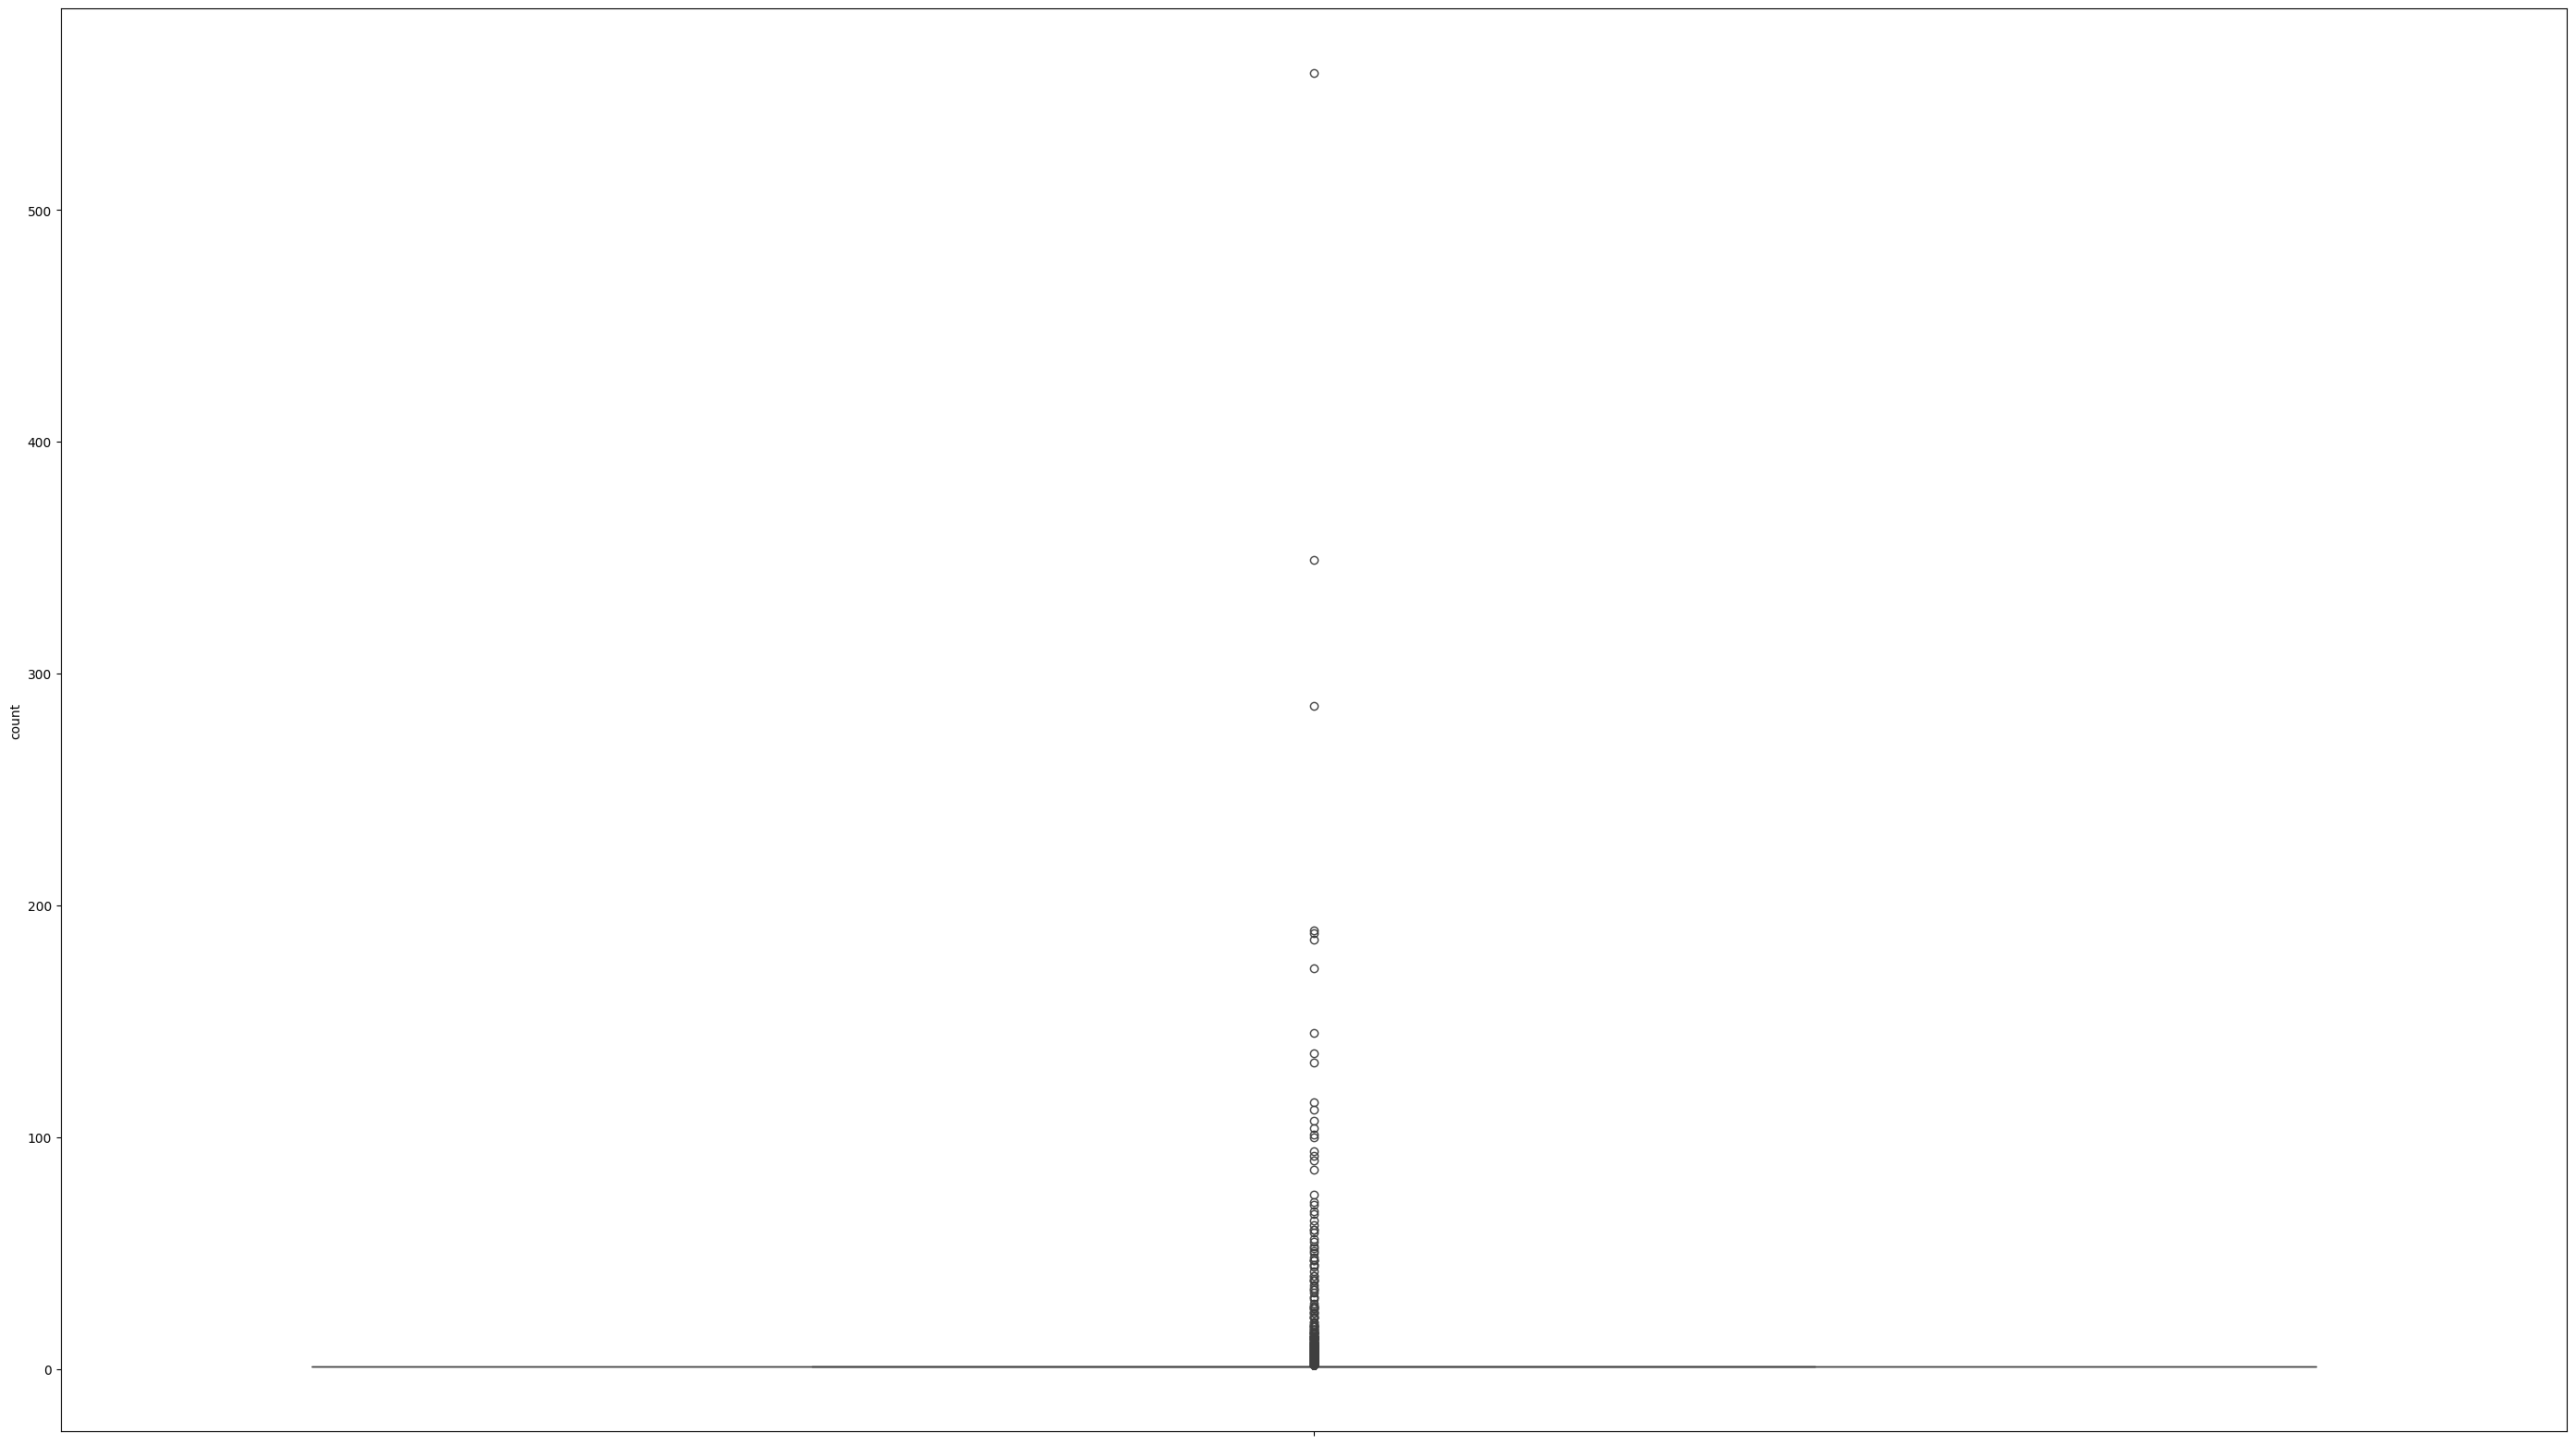

In [11]:
# Глянем на боксплот 
fig, axes = plt.subplots(1, 1, figsize=(35, 20))
sns.boxplot(
    visitors_transaction["count"],
    ax=axes
)

plt.show()

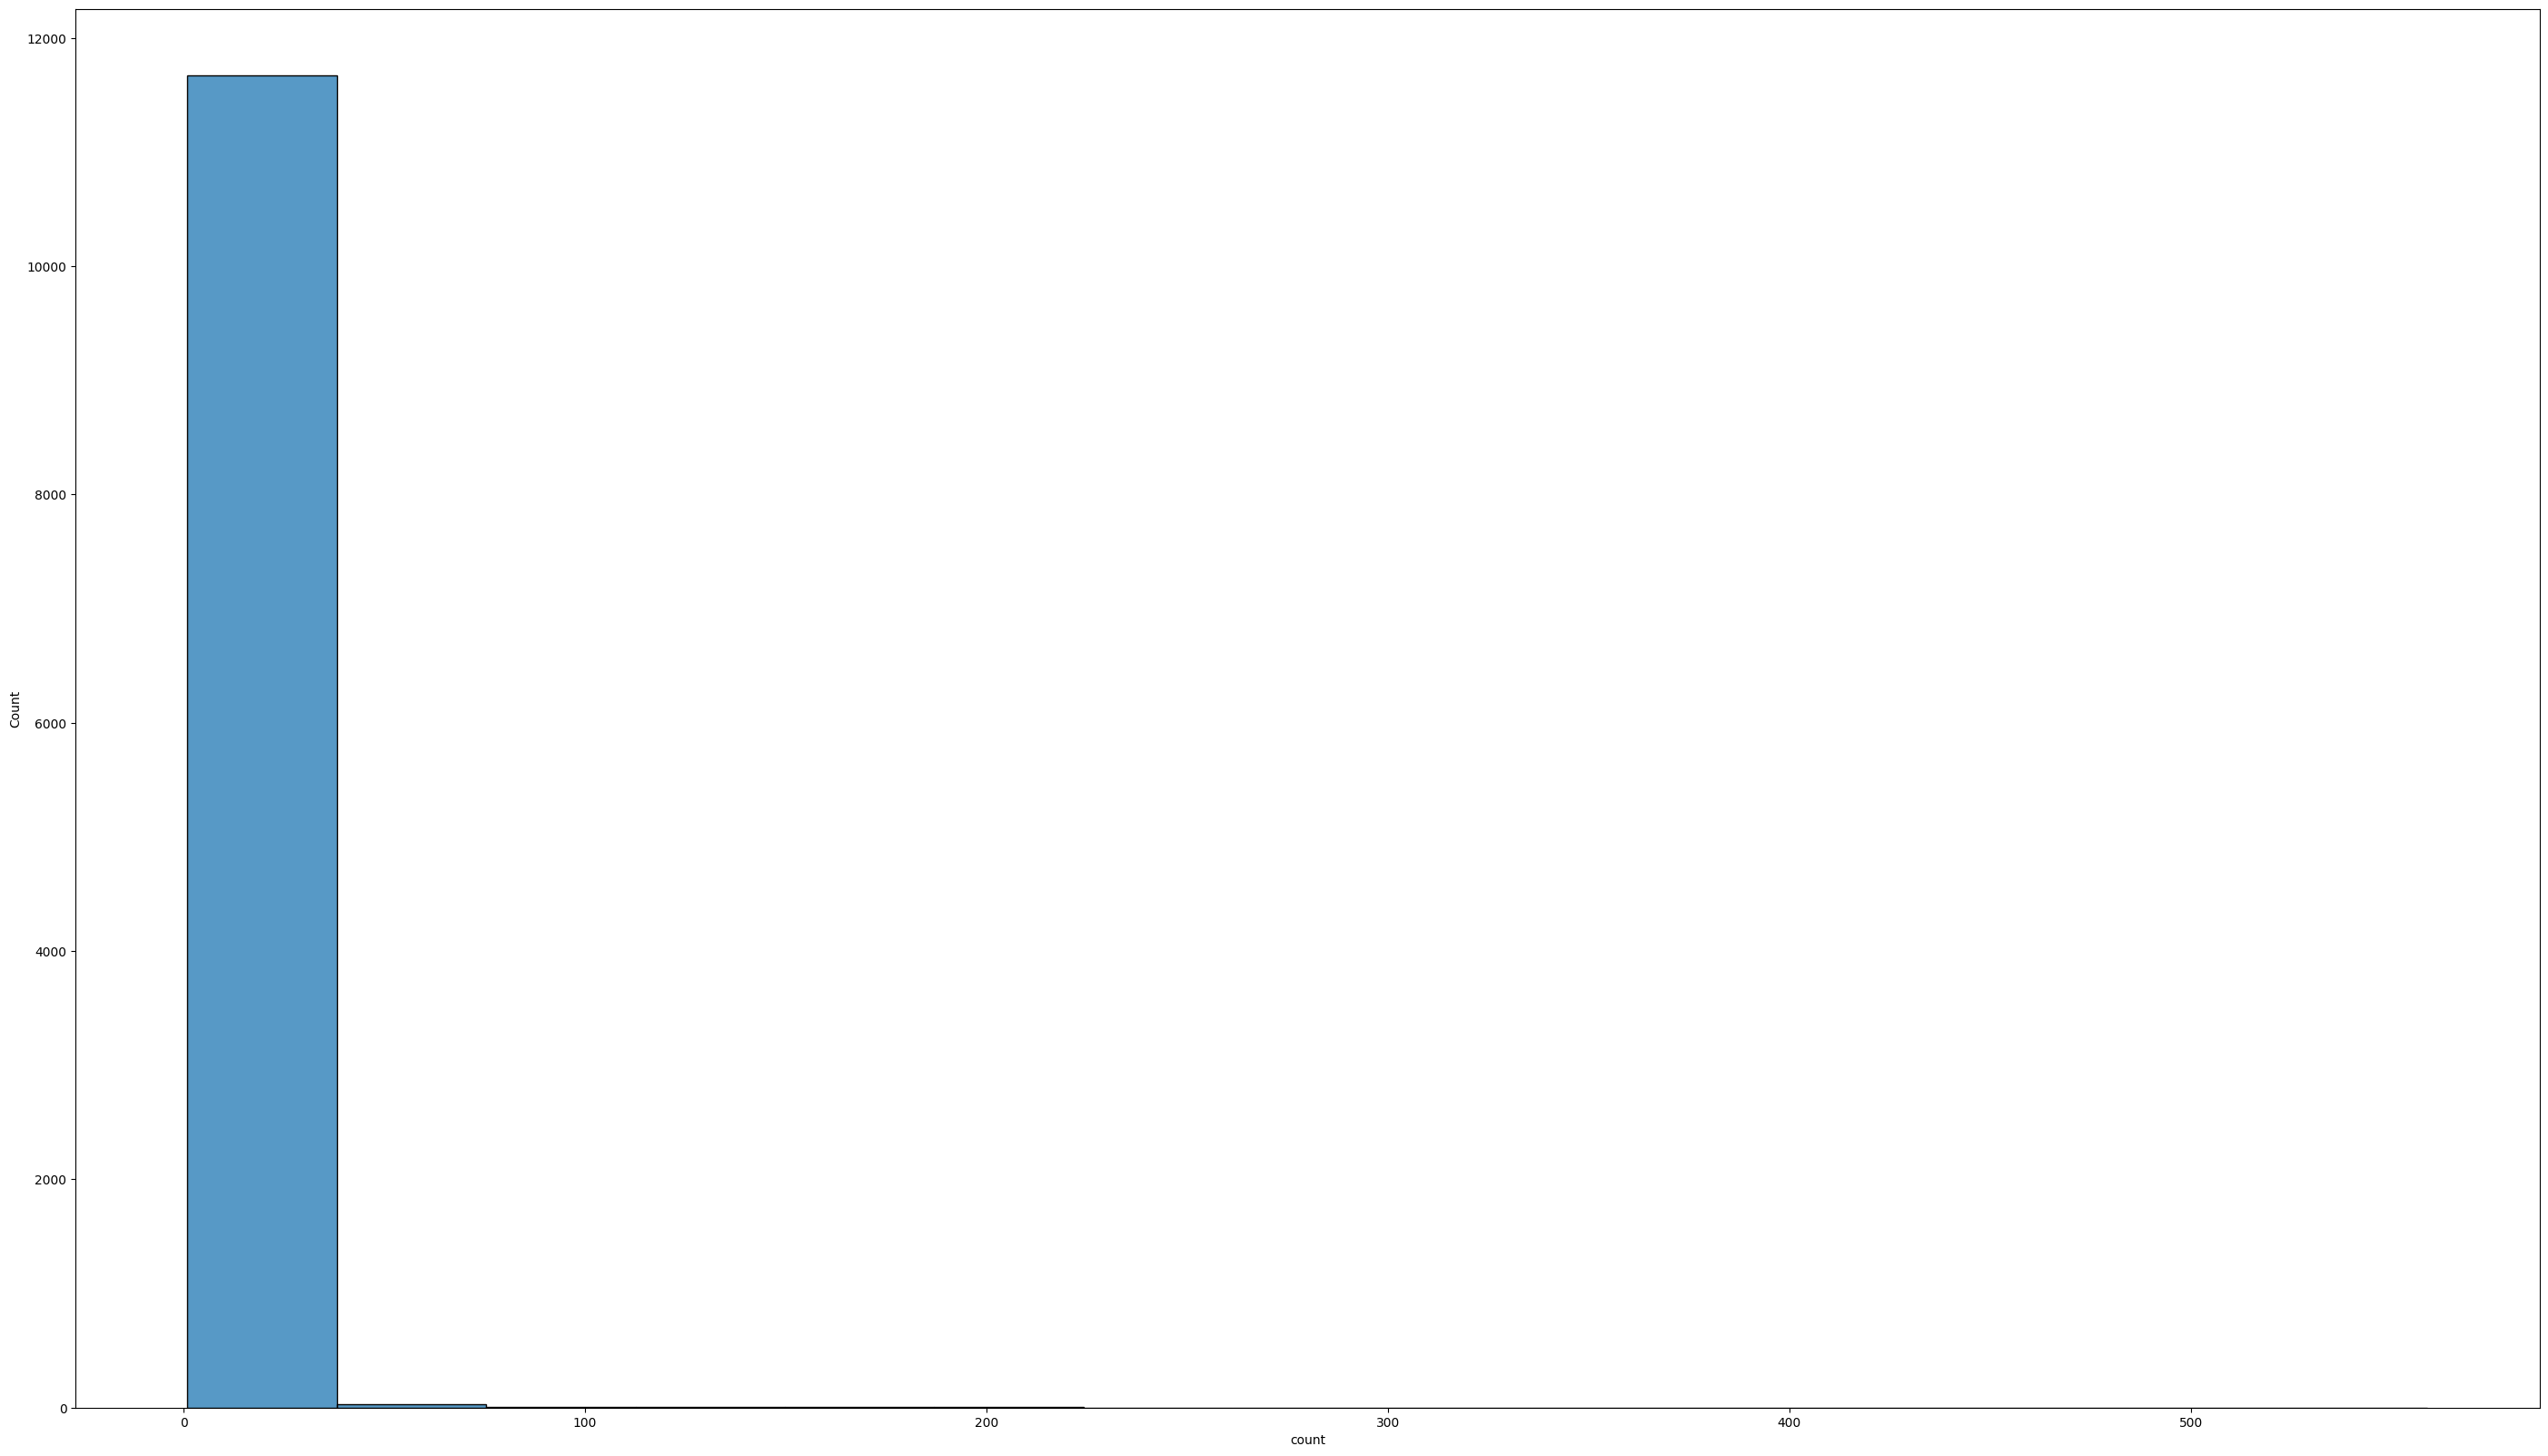

In [12]:
# Посмотрим гистрограмму распределения
fig, axes = plt.subplots(1, 1, figsize=(35, 20))
sns.histplot(
    visitors_transaction["count"],
    ax=axes
)

plt.show()

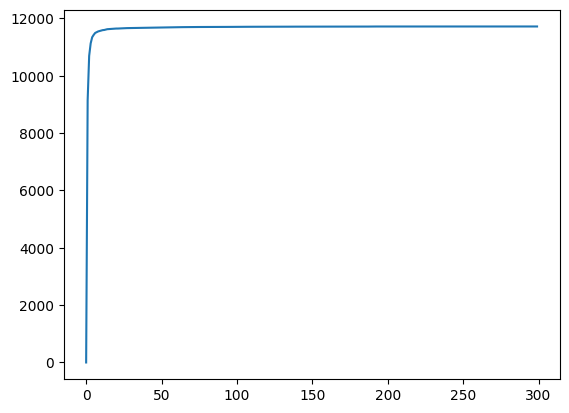

In [13]:
# Визуализируем диапазон в котором находится основная часть покупок по id
product_list = []
for i in range(300):
    product_list.append(
        visitors_transaction[visitors_transaction["count"] <= i].shape[0])

# Посмотрим переломный момент по покупкам
sns.lineplot(product_list)
plt.show()

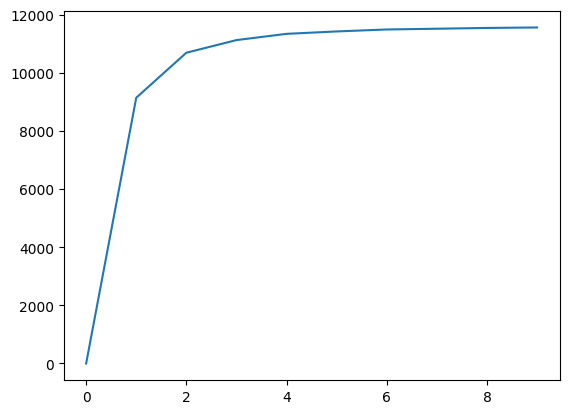

In [14]:
# Уменьшим скоуп для визуализации
product_list = []
for i in range(10):
    product_list.append(
        visitors_transaction[visitors_transaction["count"] <= i].shape[0])

# Посмотрим переломный момент по покупкам
sns.lineplot(product_list)
plt.show()

#### Можно видеть, что основная часть покупателей совершает покупки до ~4-6 штук, при этом описание статистик говорит о среднем равном 2 и стандартном отклонении равном 9, поскольку отрицательные значения не допускаются, это может указывать на то, что данное распределение имеет смещение вправо. Также можно предположить, что большинство значений сконцентрированы справа от среднего значения, но при этом имеют большой разброс распределение равномерно, но наличествуют аномалии в данных, которые могут свидетельствовать о наличии оптовых покупателей, для которых разрабатываемая системе рекомендаций не имеет смысла в виду B2B формата закупок этих агентов.

#### Предварительно запомним границу отсечения датасета по параметру количества покупок.

____

### Посмотрим что можно сделать с transactionid

In [15]:
# Число уникальных значений
events["transactionid"].nunique()

17672

In [16]:
# Что у нас есть по событиям
events["event"].value_counts()

event
view           2664312
addtocart        69332
transaction      22457
Name: count, dtype: int64

In [17]:
events.query("event == 'view'")["transactionid"].value_counts()

Series([], Name: count, dtype: int64)

In [18]:
events.query("event == 'addtocart'")["transactionid"].value_counts()

Series([], Name: count, dtype: int64)

In [19]:
events.query("event == 'transaction'")["transactionid"].value_counts()

transactionid
7063.0     31
765.0      28
8351.0     27
2753.0     23
6993.0     21
           ..
17515.0     1
1200.0      1
8006.0      1
15418.0     1
17579.0     1
Name: count, Length: 17672, dtype: int64

> transactionid, что характерно, заполнен только в случае проведения транзации, что может быть малоинформативно, дропнем этот фит, а event за кодируем, так как у нас всего три типа событий.

In [20]:
# One-hot
events = pd.concat([events, pd.get_dummies(events["event"], dtype=int)], axis=1)

# Дроп ненужных фитоф
events.drop(["transactionid"], axis=1, inplace=True)

events.head()

,timestamp,visitorid,event,itemid,addtocart,transaction,view
0,2015-06-02 05:02:12.117,257597,view,355908,0,0,1
1,2015-06-02 05:50:14.164,992329,view,248676,0,0,1
2,2015-06-02 05:13:19.827,111016,view,318965,0,0,1
3,2015-06-02 05:12:35.914,483717,view,253185,0,0,1
4,2015-06-02 05:02:17.106,951259,view,367447,0,0,1


In [43]:
#Заготовим на будущее фрейм покупателей
customers = events.copy()
customers = customers.drop(["event"], axis=1)


In [44]:
# Нам нужно аггрегировать просмотры, транзакции и добавления в корзину 
customers["timestamp"] = customers["timestamp"].dt.date
customers

,timestamp,visitorid,itemid,addtocart,transaction,view
0,2015-06-02,257597,355908,0,0,1
1,2015-06-02,992329,248676,0,0,1
2,2015-06-02,111016,318965,0,0,1
3,2015-06-02,483717,253185,0,0,1
4,2015-06-02,951259,367447,0,0,1
...,...,...,...,...,...,...
2756096,2015-08-01,591435,261427,0,0,1
2756097,2015-08-01,762376,115946,0,0,1
2756098,2015-08-01,1251746,78144,0,0,1
2756099,2015-08-01,1184451,283392,0,0,1


In [45]:
# Сформируем датафрейм содержащий количество просмотров, добавлений в корзину и покупок
# в ра
customers = (
    customers.groupby(by=["timestamp", "visitorid", "itemid"])[
        ["addtocart", "transaction", "view"]
    ]
    .sum()
    .reset_index()
)

customers

,timestamp,visitorid,itemid,addtocart,transaction,view
0,2015-05-03,12,70225,0,0,1
1,2015-05-03,385,47324,0,0,1
2,2015-05-03,1250,112022,0,0,1
3,2015-05-03,1525,45559,0,0,1
4,2015-05-03,1701,120233,0,0,1
...,...,...,...,...,...,...
2271474,2015-09-18,1403311,285209,0,0,1
2271475,2015-09-18,1403393,79705,0,0,1
2271476,2015-09-18,1403393,331032,0,0,2
2271477,2015-09-18,1403515,23388,0,0,1


----

### Посмотрим itemid таблицы events: распределение, уникальные значения, пропуски

In [22]:
# Глянем есть ли пропущенные значения
events["itemid"].isna().value_counts()

itemid
False    2756101
Name: count, dtype: int64

> Пропусков нет

In [23]:
# Посмотрим на количество уникальных товаров 
events["itemid"].nunique()

235061

> Что предсказуемо количество уникальных товаров значительно уступает количеству уникальных пользователей

In [24]:
# Вычленим idшники товаров которые были куплены
item_transaction = pd.DataFrame(
    events["itemid"][events["event"] == "transaction"].value_counts()
).reset_index()

item_transaction.head()

,itemid,count
0,461686,133
1,119736,97
2,213834,92
3,312728,46
4,7943,46


In [27]:
# Посмотрим на статистики
item_transaction.describe()

,itemid,count
count,12025.000000,12025.000000
mean,233918.108857,1.867526
std,133811.807113,2.710560
min,15.000000,1.000000
25%,117674.000000,1.000000
50%,234299.000000,1.000000
75%,349516.000000,2.000000
max,466861.000000,133.000000


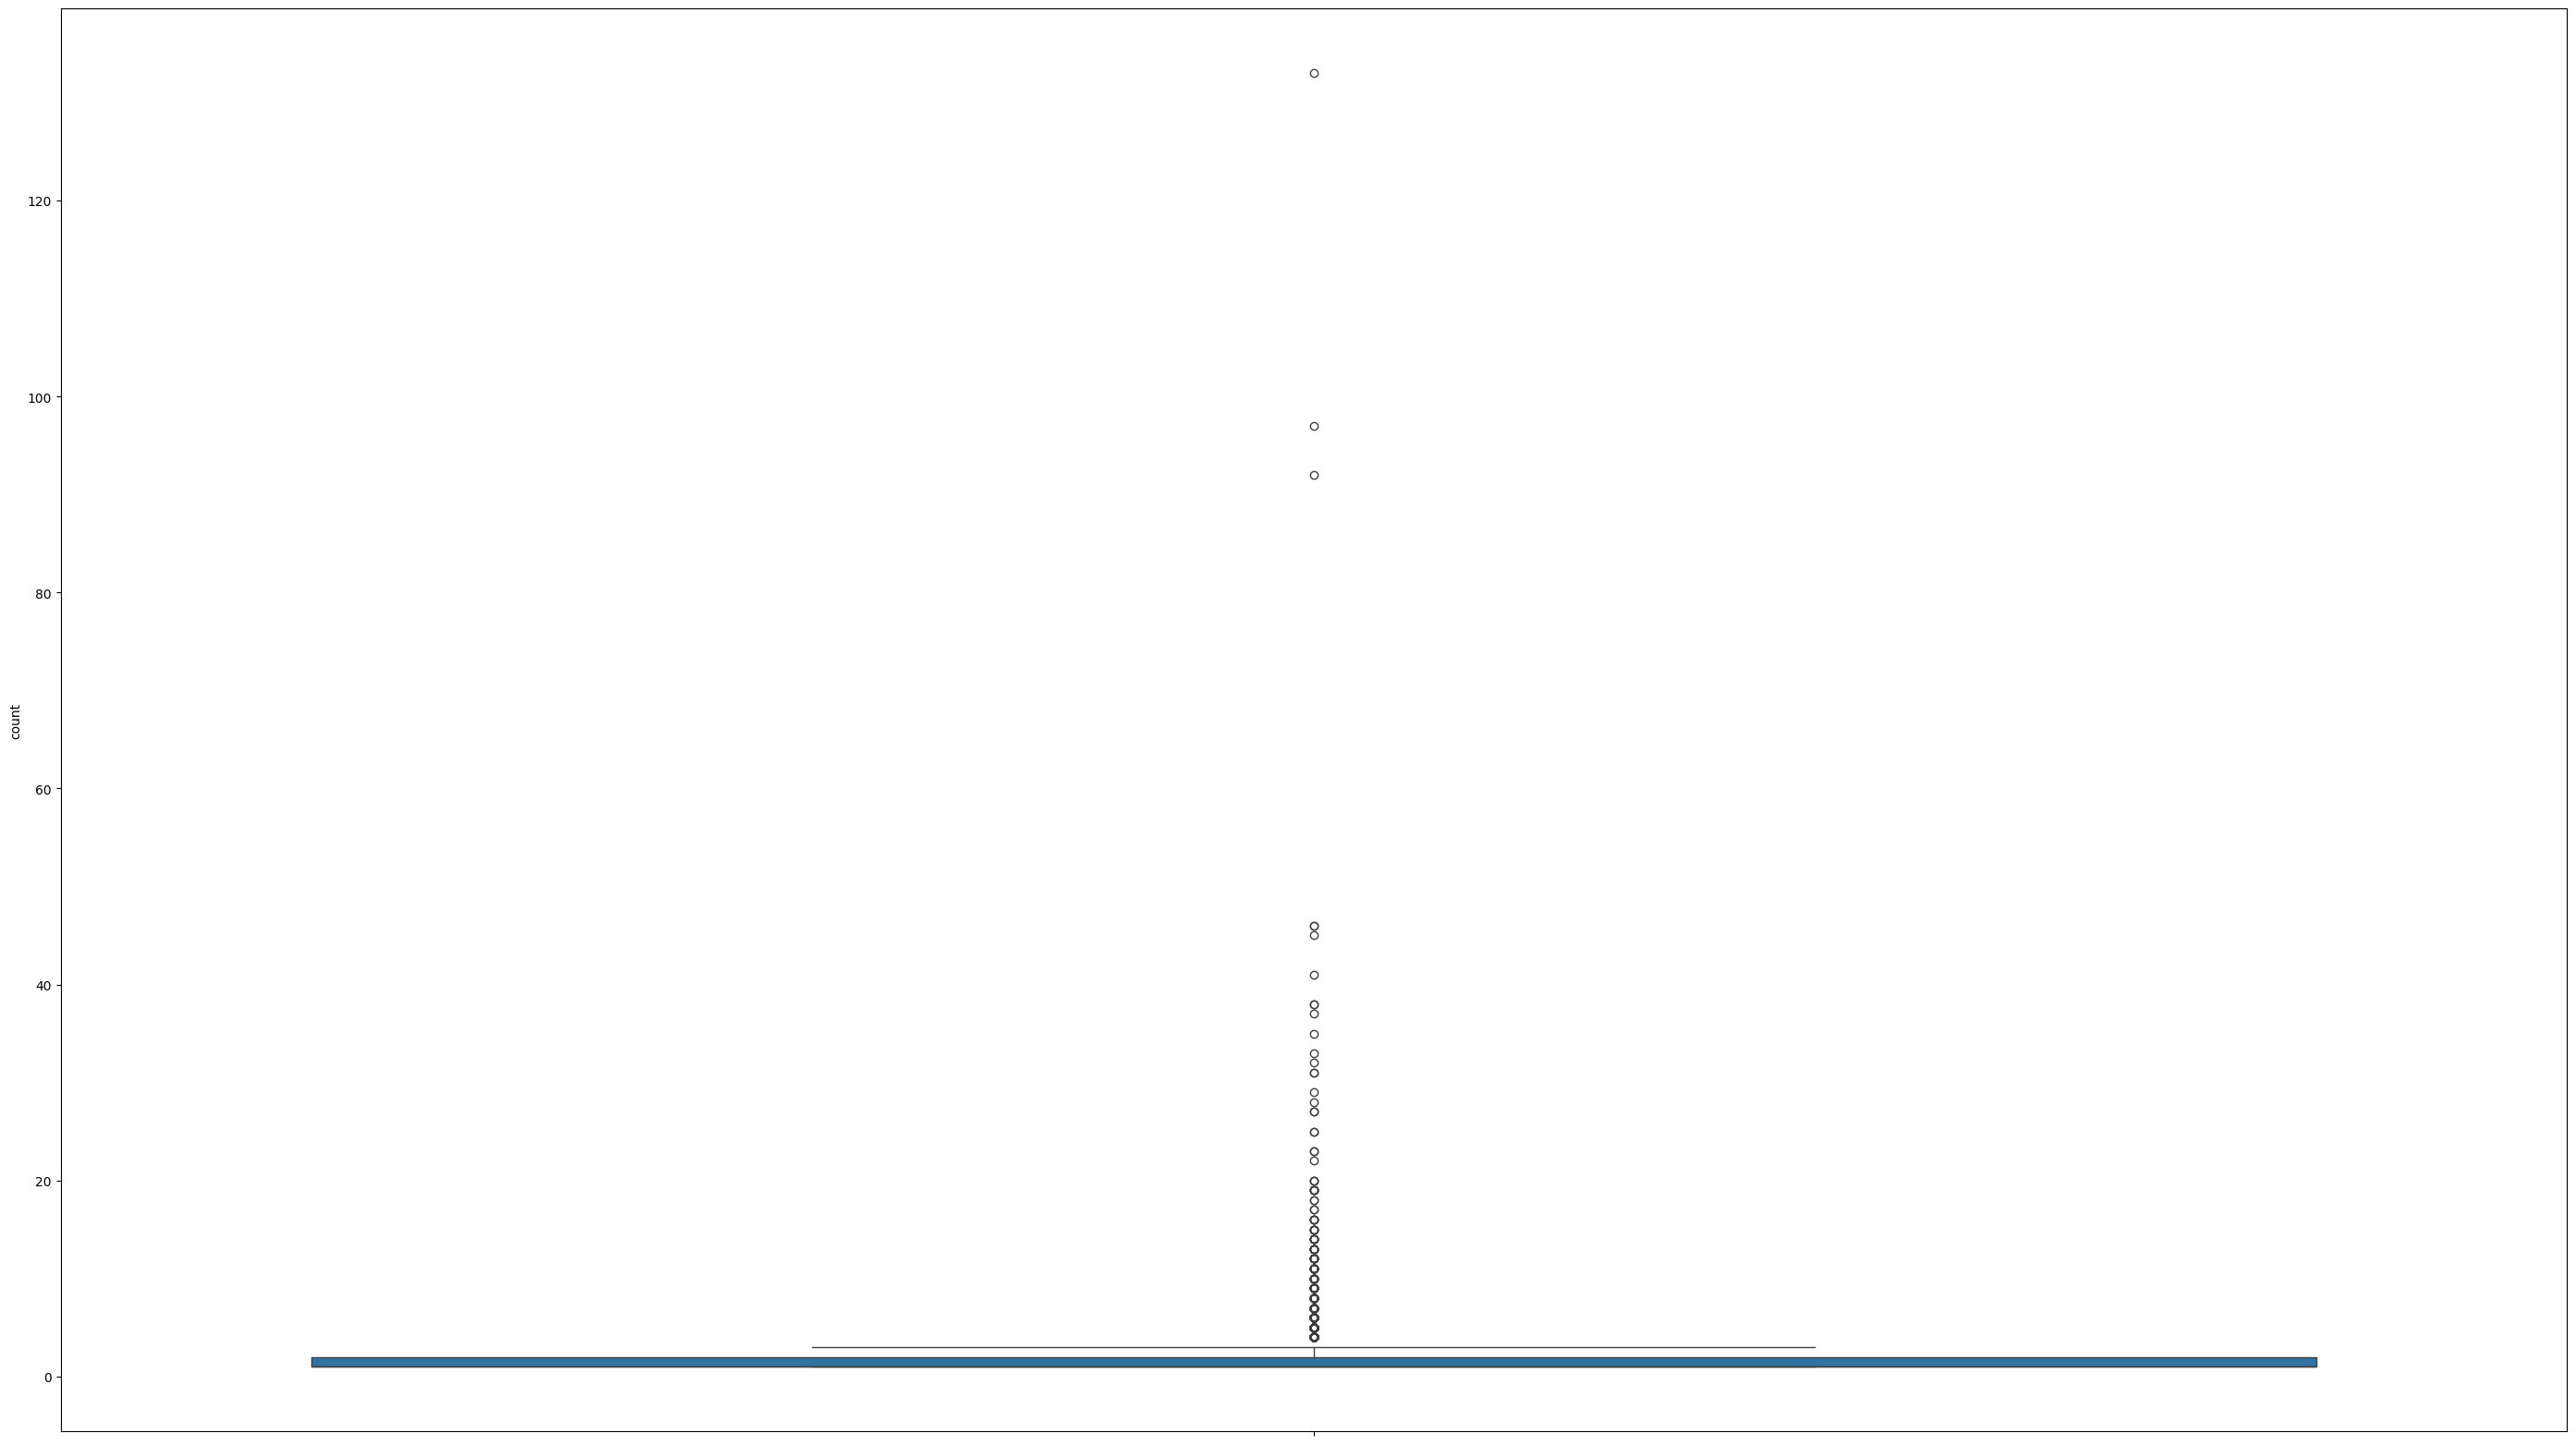

In [28]:
# Глянем на боксплот 
fig, axes = plt.subplots(1, 1, figsize=(35, 20))
sns.boxplot(
    item_transaction["count"],
    ax=axes
)

plt.show()

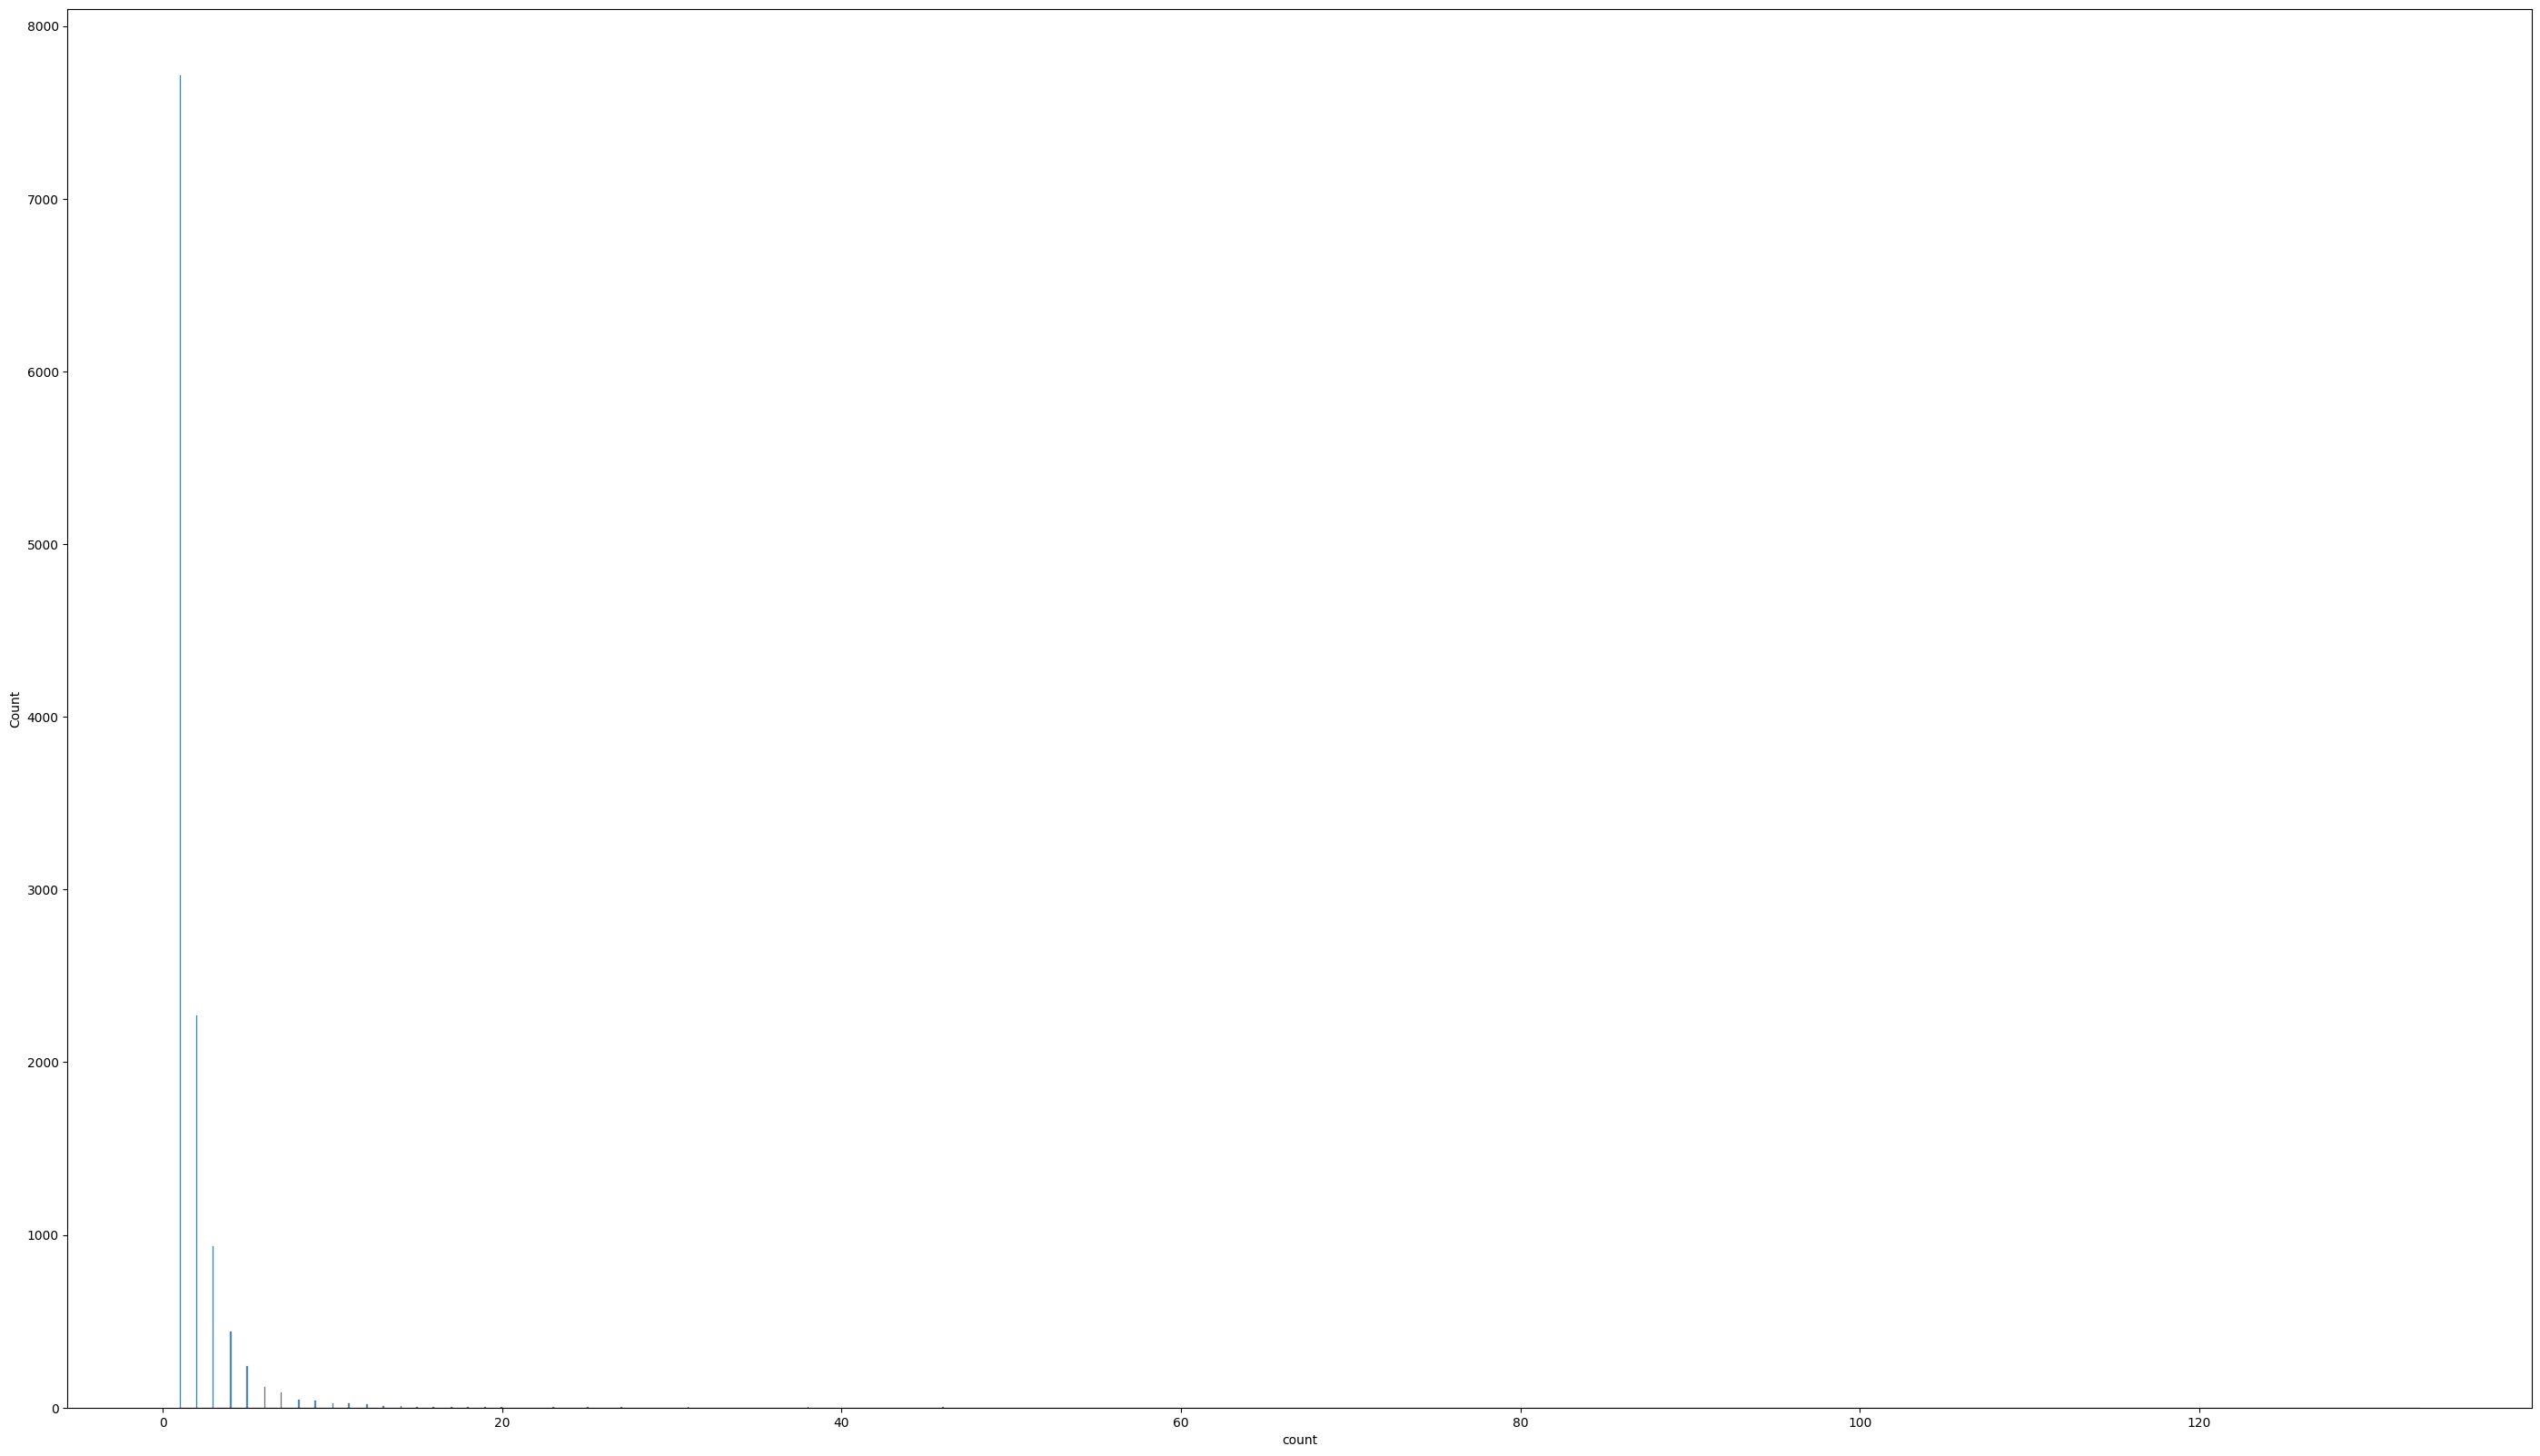

In [29]:
# Посмотрим гистрограмму распределения
fig, axes = plt.subplots(1, 1, figsize=(35, 20))
sns.histplot(
    item_transaction["count"],
    ax=axes
)

plt.show()

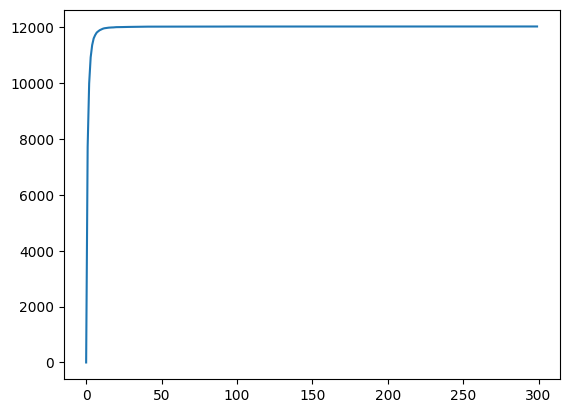

In [30]:
# Визуализируем диапазон в котором находится основная часть покупок по id
product_list = []
for i in range(300):
    product_list.append(
        item_transaction[item_transaction["count"] <= i].shape[0])

# Посмотрим переломный момент по покупкам
sns.lineplot(product_list)
plt.show()

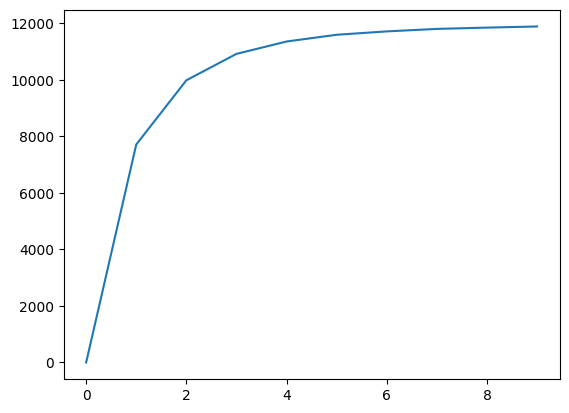

In [31]:
# Уменьшим скоуп для визуализации
product_list = []
for i in range(10):
    product_list.append(
        item_transaction[item_transaction["count"] <= i].shape[0])

# Посмотрим переломный момент по покупкам
sns.lineplot(product_list)
plt.show()

#### Можно видеть, ЗАПОЛНИТЬ

#### Предварительно ЗАПОЛНИТЬ

____

#### Поработаем с датафреймами item_properties и category_tree

In [32]:
# Поработаем со свойствами товаров, сначала приведем property к int64, 
# как было указано в property лежат категории + хеши остальных свойств,
# следовательно переведя в числовой формат и перехватив ошибку в нан мы должны
# оставить только категории.

item_properties["property"] = pd.to_numeric(item_properties["property"], errors='coerce')

In [33]:
# Удалим пропуски
item_properties.dropna(inplace=True)

In [34]:
# Переименуем property в categoryid
item_properties.rename(columns={"property":"categoryid"}, inplace=True)
item_properties.head()

,timestamp,itemid,categoryid,value
1,2015-09-06 03:00:00,206783,888.0,1116713 960601 n277.200
2,2015-08-09 03:00:00,395014,400.0,n552.000 639502 n720.000 424566
3,2015-05-10 03:00:00,59481,790.0,n15360.000
4,2015-05-17 03:00:00,156781,917.0,828513
6,2015-06-14 03:00:00,89534,213.0,1121373


In [35]:
# Добавим свойство родительской категории из фрейма category_tree
item_properties = \
pd.merge(
    left=item_properties, right=category_tree, left_on="categoryid", right_on="categoryid"
)

item_properties.head()

,timestamp,itemid,categoryid,value,parentid
0,2015-09-06 03:00:00,206783,888.0,1116713 960601 n277.200,866.0
1,2015-08-09 03:00:00,395014,400.0,n552.000 639502 n720.000 424566,110.0
2,2015-05-10 03:00:00,59481,790.0,n15360.000,1492.0
3,2015-05-17 03:00:00,156781,917.0,828513,1374.0
4,2015-06-14 03:00:00,89534,213.0,1121373,1299.0


In [36]:
# Удалим временную метку 
item_properties.drop(["timestamp"], axis=1, inplace=True)
item_properties.head()

,itemid,categoryid,value,parentid
0,206783,888.0,1116713 960601 n277.200,866.0
1,395014,400.0,n552.000 639502 n720.000 424566,110.0
2,59481,790.0,n15360.000,1492.0
3,156781,917.0,828513,1374.0
4,89534,213.0,1121373,1299.0


In [37]:
# Токенезируем value и переименуем во что-то более вразумительное
items = item_properties.rename(columns={"value":"charac"})

# Создадим функцию для токенизации
def item_prop_tokenizer(prop):
    prop = prop.replace("n", "")
    numeric_list = []
    for x in prop.split():
        try:
            numeric_list.append(float(x))
        except ValueError:
            numeric_list.append(float(0))
    return numeric_list

items["charac"] = items["charac"].apply(item_prop_tokenizer)
items.head()

,itemid,categoryid,charac,parentid
0,206783,888.0,"[1116713.0, 960601.0, 277.2]",866.0
1,395014,400.0,"[552.0, 639502.0, 720.0, 424566.0]",110.0
2,59481,790.0,[15360.0],1492.0
3,156781,917.0,[828513.0],1374.0
4,89534,213.0,[1121373.0],1299.0


----

### Теперь у нас есть два датафрейма содержашие сущности связаные с покупателями и связаные с товарами, глянем их.

In [38]:
customers.head()

,timestamp,visitorid,itemid,addtocart,transaction,view
0,2015-06-02 05:02:12.117,257597,355908,0,0,1
1,2015-06-02 05:50:14.164,992329,248676,0,0,1
2,2015-06-02 05:13:19.827,111016,318965,0,0,1
3,2015-06-02 05:12:35.914,483717,253185,0,0,1
4,2015-06-02 05:02:17.106,951259,367447,0,0,1


In [51]:
customers.query("transaction == 1")

,timestamp,visitorid,itemid,addtocart,transaction,view
130,2015-06-02 05:17:56.276,599528,356475,0,1,0
304,2015-06-01 21:18:20.981,121688,15335,0,1,0
418,2015-06-01 21:25:15.008,552148,81345,0,1,0
814,2015-06-01 16:38:56.375,102019,150318,0,1,0
843,2015-06-01 16:01:58.180,189384,310791,0,1,0
...,...,...,...,...,...,...
2755294,2015-07-31 21:12:56.570,1050575,31640,0,1,0
2755349,2015-07-31 21:57:58.779,861299,456602,0,1,0
2755508,2015-07-31 15:48:50.123,855941,235771,0,1,0
2755603,2015-07-31 15:12:40.300,548772,29167,0,1,0


In [75]:
test = customers.copy()
test

,timestamp,visitorid,itemid,addtocart,transaction,view
0,2015-06-02 05:02:12.117,257597,355908,0,0,1
1,2015-06-02 05:50:14.164,992329,248676,0,0,1
2,2015-06-02 05:13:19.827,111016,318965,0,0,1
3,2015-06-02 05:12:35.914,483717,253185,0,0,1
4,2015-06-02 05:02:17.106,951259,367447,0,0,1
...,...,...,...,...,...,...
2756096,2015-08-01 03:13:05.939,591435,261427,0,0,1
2756097,2015-08-01 03:30:13.142,762376,115946,0,0,1
2756098,2015-08-01 02:57:00.527,1251746,78144,0,0,1
2756099,2015-08-01 03:08:50.703,1184451,283392,0,0,1


In [76]:
test = test.groupby(by=["visitorid", "itemid"])[["view", "transaction", "addtocart"]].sum()
test = pd.DataFrame(test).reset_index()
test

,visitorid,itemid,view,transaction,addtocart
0,0,67045,1,0,0
1,0,285930,1,0,0
2,0,357564,1,0,0
3,1,72028,1,0,0
4,2,216305,2,0,0
...,...,...,...,...,...
2145174,1407575,121220,1,0,0
2145175,1407576,356208,1,0,0
2145176,1407577,427784,1,0,0
2145177,1407578,188736,1,0,0


In [77]:
test.query("transaction == 1")

,visitorid,itemid,view,transaction,addtocart
244,172,10034,5,1,1
265,172,465522,3,1,2
280,186,49029,2,1,1
371,264,161949,2,1,1
372,264,459835,1,1,1
...,...,...,...,...,...
2143977,1406787,336832,5,1,0
2144290,1406981,436004,1,1,1
2144406,1407070,215596,0,1,1
2144465,1407110,360922,6,1,1


In [39]:
items.head()

,itemid,categoryid,charac,parentid
0,206783,888.0,"[1116713.0, 960601.0, 277.2]",866.0
1,395014,400.0,"[552.0, 639502.0, 720.0, 424566.0]",110.0
2,59481,790.0,[15360.0],1492.0
3,156781,917.0,[828513.0],1374.0
4,89534,213.0,[1121373.0],1299.0
